/opt/anaconda/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


First column: X17Networks_LH_VisCent_ExStr_1
(should be 'X17Networks_LH_VisCent_ExStr_1')
Last column: CAU.lh (should be 'CAU.lh)


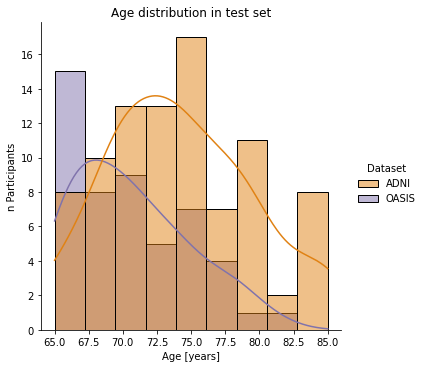

--- svr ---
On average, predicted age of 1_CN_ADNI_OASIS differed by -0.7003098183641631 years from their chronological age.
MAE = 2.033813381076068, R2 = 0.7670436294475791
Orange color representing ADNI, purple color representing OASIS
OASIS:
MAE = 2.101060777582133, R2 = 0.6455874856192374
ADNI:
MAE = 1.9960339448367057, R2 = 0.7691834440013599


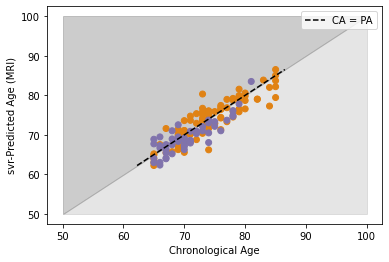

3.6636058399034206 0.2172030267179219 -0.2945850805721102


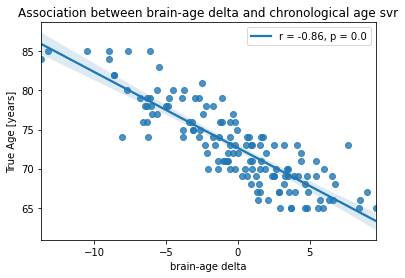

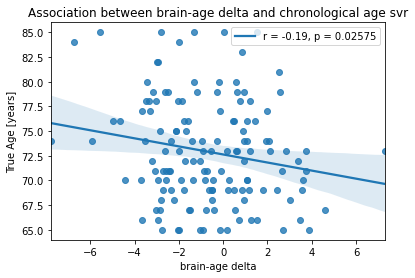

Significant correlations between BPAD and Neuropsychology


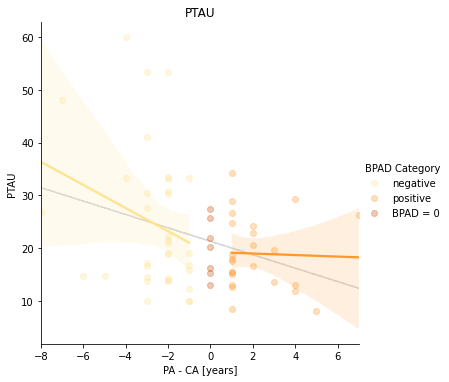

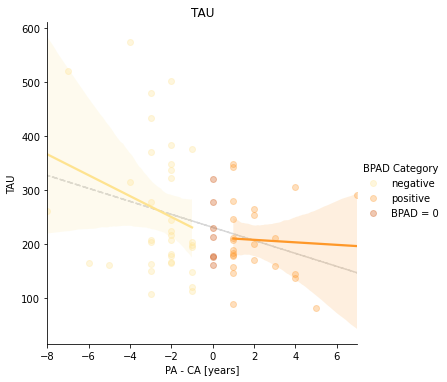

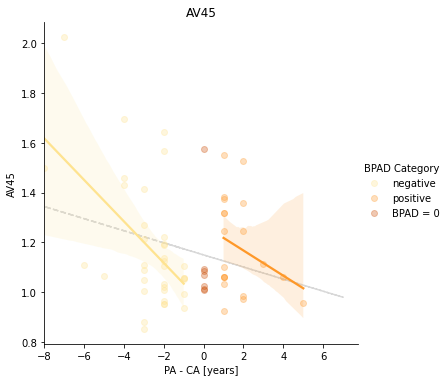

PTAU : -0.316
TAU : -0.313
AV45 : -0.262
PTAU significant in positive BPAD:  False  (-0.07203941713602124, 0.7379913597505924) 
significant in negative BPAD:  False  (-0.28616513676328637, 0.0956040402715145)
TAU significant in positive BPAD:  False  (-0.07804567807795991, 0.7169882101779771) 
significant in negative BPAD:  False  (-0.26953701290809295, 0.11738860513655788)
AV45 significant in positive BPAD:  False  (-0.26153956807276424, 0.2653410402892113) 
significant in negative BPAD:  True  (-0.510625443858411, 0.0014624107483236668)
PTAU significant in amyloid positives:  True  (-0.5246681744944413, 0.00495962786906412) 
significant in amyloid negatives:  False  (0.09586659289704219, 0.5615451978992702)


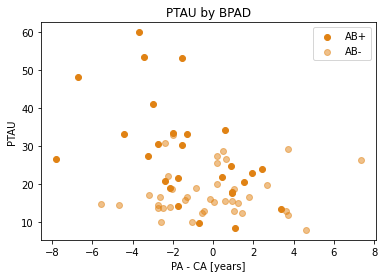

TAU significant in amyloid positives:  True  (-0.5198199539473217, 0.005451307821808509) 
significant in amyloid negatives:  False  (0.05520893128333405, 0.7385177704802821)


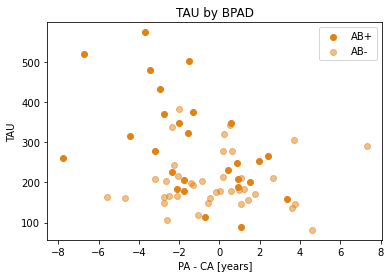

AV45 significant in amyloid positives:  True  (-0.39940733219019464, 0.04323387695464519) 
significant in amyloid negatives:  False  (-0.03980345560432669, 0.8150645196846655)


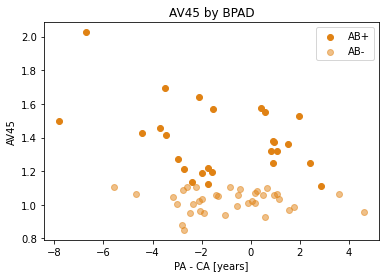

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec  3 11:02:12 2021
*
@author: doeringe
"""
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

import pickle

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score

import plots
import neuropsychology_correlations
# %%
# matplotlib config
cm_all = pickle.load(open("../data/config/plotting_config.p", "rb"))

# %%
# LOAD DATA
# load and inspect data, set modality
# TODO: stratify by age group (young old, middle old, oldest-old)
# modality = input("Which modality are you analyzing? ")
modality = 'MRI'
database = "1_CN_ADNI_OASIS"
mode = "test"
df = pd.read_csv('../data/ADNI/test_train_' + modality + '.csv')
df['PTGENDER'] = [0 if x == "Male" else 1 for x in df['PTGENDER'].values]
final_model = ['svr' if modality == 'PET' else 'svr' if modality == "MRI" else "NAN"][0]

# during cross-validation, gb was best for PET
# and rvr was best for MRI
model_all = pickle.load(open('../results/' + database +
                             '/model_{}_{}.p'.format(
    final_model, modality), "rb"))
intercept_ = model_all['intercept']
slope_ = model_all['slope']
model_ = model_all['model']

# select columns with '_' which are col's with features
col = df.columns[4:-23].tolist()
print("First column: {}".format(col[0]) +
      "\n(should be 'X17Networks_LH_VisCent_ExStr_1')" +
      "\nLast column: {}".format(col[-1]) +
      " (should be 'CAU.lh)")

# %%
# TESTING

# How well does the model perform on unseen data?
df_test = df[df['train'] == False]
df_test = df_test.reset_index(drop=True)
db_test = df_test['Dataset'].tolist()
mode = "test"

# investigate age distribution
# plot hist with Ages of train data
sns.displot(df_test, x='age', kde=True, hue='Dataset', palette=cm_all)
plt.title('Age distribution in test set')
plt.xlabel('Age [years]')
plt.ylabel('n Participants')
plt.savefig('../results/{}/plots/{}_age_distribution'.format(database,
                                                             modality) +
            '_test.png',
            bbox_inches="tight")
plt.show()

X_test = df_test[col]
y_true = df_test['age'].values

# plot model predictions against GT in test set
y_pred = model_.predict(X_test)
#y_pred_bc = (y_pred - intercept_)/slope_
y_pred_bc = y_pred - (slope_*y_true + intercept_)


# %%
plots.real_vs_pred_2(y_true, y_pred_bc, final_model, modality,
                     mode, database, db_test)

print(mean_absolute_error(y_true,y_pred),
      r2_score(y_true,y_pred),
      np.mean(y_pred-y_true))

# %%
# CHECK BIAS
plots.check_bias(y_true, y_pred, final_model, "{}_test".format(modality),
                 database=database)

plots.check_bias(y_true, y_pred_bc, final_model, "{}_test".format(modality),
                 database=database, corrected=True)

# %%
# SAVE RESULTS
# Create table of (corrected) predicted and chronological age in this modality
# rvr had better performance in both MAE and R2 --> take rvr as final model
y_diff = y_pred_bc - y_true
pred_csv = pd.concat((df_test["name"],
                      pd.DataFrame(y_true, columns=["age"]),
                      pd.DataFrame(y_pred, columns=["RawPredAge"]),
                      pd.DataFrame(y_pred_bc, columns=["CorrPredAge"]),
                      pd.DataFrame(y_diff, columns=["BPAD"])), axis=1)

pred_csv.to_csv('../results/pred_age_{}_{}.csv'.format(modality, final_model))


# %%
# CORRELATION NEUROPSYCHOLOGY - BRAIN AGE
# Inspect correlation of neuropsychological scores and predicted/corrected
# brain age
npt = df_test.columns[-19:-2].values

sign_npt = neuropsychology_correlations.neuropsych_correlation(df_test['age'], y_pred_bc,
                                                               "BPAD",
                                                               npt,
                                                               df_test,
                                                               modality,
                                                               database)

# %%
# INTERACTION EFFECTS WITH BPAD
for k in sign_npt:
    exc = np.isnan(df_test[k])
    pos = df_test['BPAD Category'] == 'positive'
    neg = df_test['BPAD Category'] == 'negative'
    
    pos_bool = np.array(~exc) & np.array(pos)
    neg_bool = np.array(~exc) & np.array(neg)
    pearson_pos = stats.pearsonr(y_diff[pos_bool],
                                 df_test[k][pos_bool])
    pearson_neg = stats.pearsonr(y_diff[neg_bool],
                                 df_test[k][neg_bool])
    print(k, "\033[1msignificant in positive BPAD: ", pearson_pos[1] < 0.05,
          "\033[0m", pearson_pos,
          "\n\033[1msignificant in negative BPAD: ", pearson_neg[1] < 0.05,
          "\033[0m", pearson_neg)
# %%
# interaction with amyloid status?

for k in sign_npt:
    exc = np.array(np.isnan(df_test[k]))
    pet_exc = np.isnan(df_test['AV45'])
    pet_pos = df_test['AV45'] >= 1.11
    pet_neg = df_test['AV45'] < 1.11
    pet_pos = np.array(pet_pos) & np.array(~pet_exc)
    pet_neg = np.array(pet_neg) & np.array(~pet_exc)

    csf_exc = np.isnan(df_test['ABETA'])
    csf_pos = df_test['ABETA'] < 977
    csf_neg = df_test['ABETA'] >= 977
    csf_pos = np.array(csf_pos) & np.array(~csf_exc)
    csf_neg = np.array(csf_neg) & np.array(~csf_exc)

    pos_bool = pet_pos | csf_pos & ~(pet_neg | csf_neg)
    neg_bool = pet_neg | csf_neg & ~(pet_pos | csf_pos)

    pearson_pos = stats.pearsonr(y_diff[pos_bool & np.array(~exc)],
                                 df_test[k][pos_bool  & np.array(~exc)])
    pearson_neg = stats.pearsonr(y_diff[neg_bool  & np.array(~exc)],
                                 df_test[k][neg_bool  & np.array(~exc)])
    print(k, "\033[1msignificant in amyloid positives: ", 
          pearson_pos[1] < 0.05,
          "\033[0m", pearson_pos,
          "\n\033[1msignificant in amyloid negatives: ", 
          pearson_neg[1] < 0.05,
          "\033[0m", pearson_neg)
    plt.scatter(y_diff[pos_bool & np.array(~exc)],
                df_test[k][pos_bool  & np.array(~exc)],
                color=cm_all[0], alpha=1, label="AB+")
    plt.scatter(y_diff[neg_bool & np.array(~exc)],
                df_test[k][neg_bool  & np.array(~exc)],
                color=cm_all[0], alpha=0.5, label="AB-")
    plt.xlabel("PA - CA [years]")
    plt.ylabel(k)
    plt.title("{} by BPAD".format(k))
    plt.legend()
    plt.show()


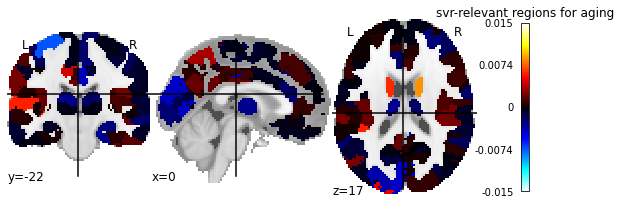

In [2]:
# %%
# PERMUTATION IMPORTANCE
pi = permutation_importance(model_,
                            X_test, y_true,
                            n_repeats=1000)


# %%
plots.permutation_imp(pi, final_model, modality, database)


In [8]:
most_imp = col[np.where(pi.importances_mean == np.max(pi.importances_mean))[0][0]]

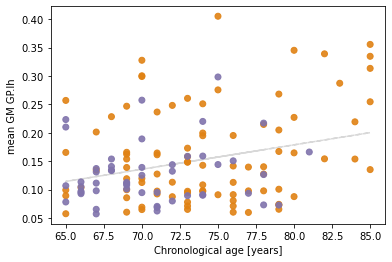

(0.29544758020262263, 0.0004140198422301956)


In [17]:
y_db_cat = [0 if x == "ADNI" else 1 for x in db_test]
plt.scatter(y_true, df_test[most_imp], c=cm_all[y_db_cat], alpha = 0.9)
pearson = stats.pearsonr(y_true, df_test[most_imp])
slope, intercept = np.polyfit(y_true, df_test[most_imp], 1)
plt.plot(y_true, slope*y_true+intercept, linestyle="--",
                         label="all", color = "gray", zorder=0, alpha=0.3)
plt.xlabel("Chronological age [years]")
plt.ylabel("mean GM {}".format(most_imp))
plt.savefig("../results/{}/plots/{}-{}XCA.jpg".format(database, modality, most_imp))
plt.show()
print(pearson)